In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [4]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
# importing rastermap
# (this will be slow the first time since it is compiling the numba functions)
#from rastermap import Rastermap, utils
from scipy.stats import zscore

from utils.neurosuite import get_unit_names_sorted
from utils.events import get_sound_event_periods, get_sound_event_period_idxs

In [5]:
from umap import UMAP
from sklearn.manifold import TSNE

2025-02-12 15:43:54.865066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 15:43:55.409165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-12 15:43:55.409228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-12 15:43:55.497541: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 15:43:56.470286: W tensorflow/stream_executor/platform/de

In [7]:
#source  = '/Users/andrey/sandbox/'
#source  = '/Users/andrey/nevermind/AG_Pecka/data/processed/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
#session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

animal      = session.split('_')[0]
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')

In [8]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

In [234]:
# unit activity matrix

# artificial binning
#bin_size = 0.25
#t_bins = np.arange(0, tl[-1][0], bin_size)

# sound events binning
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

unit_mx = zscore(unit_mx, axis=1)
unit_mx.shape

(185, 9599)

In [84]:
# OPTION 2 - few sound events unwrapped in the future
unwrap_count = 1  # plus one more event

t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])  # units, sound events
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)  # sound events, units

res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

#unit_mx_database[2] = res.T.copy()
unit_mx = res.copy()

unit_mx.shape

(404, 9598)

In [10]:
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
tsne_fit = tsne.fit_transform(unit_mx.T)
    
umap_2d = UMAP(n_components=2, n_neighbors=30, min_dist=0.5, random_state=0)
umap_fit = umap_2d.fit_transform(unit_mx.T)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [29]:
tsne_fit.shape

(9599, 2)

In [235]:
sound_events = sound_events[:len(unit_mx.T)]

x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

idxs_sta_ev = np.where(speed_ev < 0.04)[0]
idxs_run_ev = np.where(speed_ev > 0.04)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

## Same locations in TGT / SIL on the manifold

In [14]:
idxs_succ = np.concatenate([np.arange(r[0], r[1]) for r in tgt_mx[tgt_mx[:, 4] == 1]])

In [15]:
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
tgt_succ_xy = np.zeros([len(tgt_mx_succ), 2])

for i, tgt_rec in enumerate(tgt_mx[tgt_mx[:, 4] == 1]):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_xy[i] = [x_pos.mean(), y_pos.mean()]

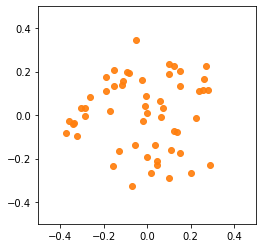

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(tgt_succ_xy[:, 0], tgt_succ_xy[:, 1], color='tab:orange', alpha=0.92)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal')

## Target beg ends

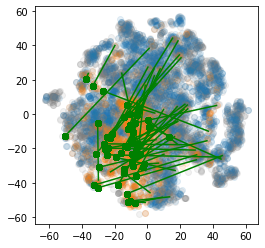

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fit = tsne_fit

ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], color='grey', alpha=0.1)
ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], color='tab:blue', alpha=0.1)
ax.scatter(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1], color='tab:orange', alpha=0.1)

offset = -10

for tgt_succ in tgt_mx_succ:
    ax.plot([fit[tgt_succ[0]][0], fit[tgt_succ[1] + offset][0]], [fit[tgt_succ[0]][1], fit[tgt_succ[1] + offset][1]],  color='green')
    ax.scatter(fit[tgt_mx_succ[:, 1] + offset][:, 0], fit[tgt_mx_succ[:, 1] + offset][:, 1], color='green')
    #ax.scatter(fit[tgt_mx_succ[:, 1] + offset][:, 0], fit[tgt_mx_succ[:, 1] + offset][:, 1], c=tgt_mx_succ[:, 1], cmap='seismic')

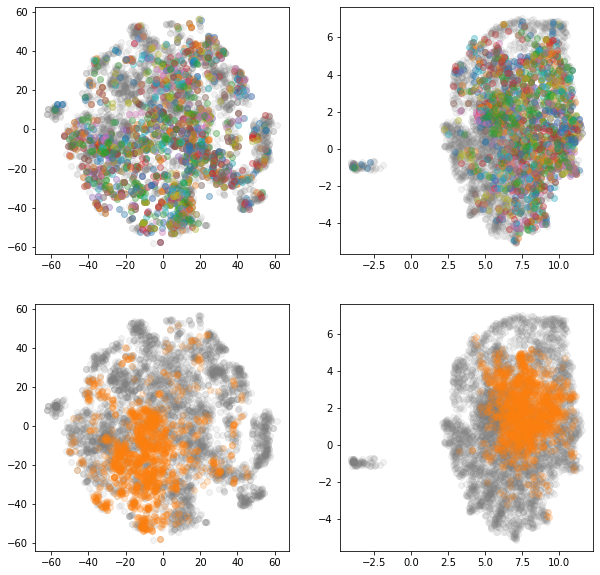

In [18]:
r_max = 0.04

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

#idxs_filt = np.intersect1d(idxs_sil_ev, idxs_sta)
idxs_filt = idxs_sil_ev
#idxs_filt = idxs_bgr_ev
#idxs_filt = idxs_tgt_ev
#idxs_filt = np.union1d(idxs_sil_ev, idxs_bgr_ev)

for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[0][i].scatter(fit[idxs_filt][:, 0], fit[idxs_filt][:, 1], color='grey', alpha=0.1)
    for tgt_xy in tgt_succ_xy:
        idxs_around_ev = np.where( (x_pos_ev - tgt_xy[0])**2 + (y_pos_ev - tgt_xy[1])**2 < r_max**2 )[0]
        idxs_around_sil_ev = np.intersect1d(idxs_around_ev, idxs_filt)
        axes[0][i].scatter(fit[idxs_around_sil_ev][:, 0], fit[idxs_around_sil_ev][:, 1], alpha=0.3)
        
for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[1][i].scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], color='grey', alpha=0.1)
    axes[1][i].scatter(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1], color='tab:orange', alpha=0.2)

In [ ]:
# dist, search for kNN
# https://stackoverflow.com/questions/6430091/efficient-distance-calculation-between-n-points-and-a-reference-in-numpy-scipy

## By speed

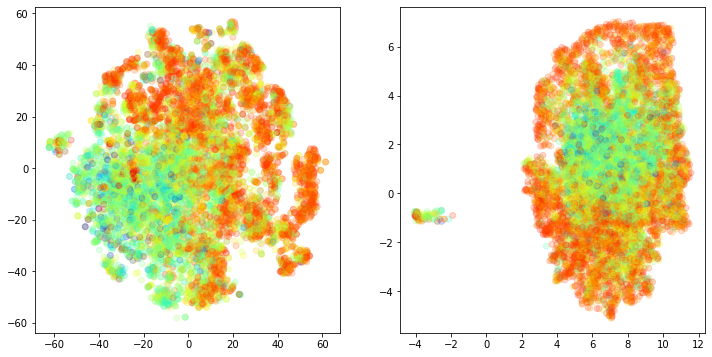

In [19]:
speed_ev_log = speed_ev.copy()
idxs_pos = np.where(speed_ev_log > 0)[0]
speed_ev_log[idxs_pos] = np.log(speed_ev_log[idxs_pos])


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

clrs = speed_ev_log
for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[i].scatter(fit[:, 0], fit[:, 1], c=clrs, cmap='jet', alpha=0.2)

## By sound

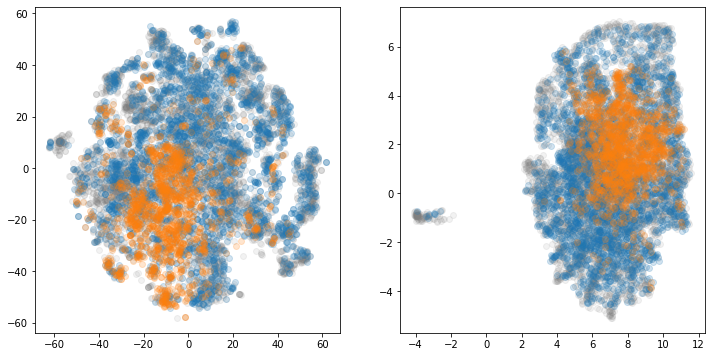

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[i].scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], color='grey', alpha=0.1)
    axes[i].scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], color='tab:blue', alpha=0.2)
    axes[i].scatter(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1], color='tab:orange', alpha=0.2)
    #axes[i].scatter(fit[idxs_di1_ev][:, 0], fit[idxs_di1_ev][:, 1], color='navy', alpha=0.2)
    #axes[i].scatter(fit[idxs_di2_ev][:, 0], fit[idxs_di2_ev][:, 1], color='red', alpha=0.2)

#     for period in get_sound_event_period_idxs(sound_events, 2):
#         if period[1] - period[0] == 24:
#             p_idxs = np.arange(period[0], period[1])
#             clrs = np.arange(len(p_idxs))
#             axes[i].scatter(fit[p_idxs][:, 0], fit[p_idxs][:, 1], c=clrs, cmap='viridis', alpha=0.3)
#             #axes[i].plot(fit[p_idxs][:, 0], fit[p_idxs][:, 1], alpha=0.7)


## By polar coordinate

In [72]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

# animal position
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]

# covert to polar
rho, phi = cart2pol(x_pos_ev, y_pos_ev)

hue = (phi + np.pi) / (2 * np.pi)  # Normalize angle to [0, 1]
alpha = np.clip(rho / np.max(rho), 0.1, 1.0)  # Normalize radius and clip for transparency

# Convert hue to RGB colors using HSV colormap
colors = plt.cm.hsv(hue)

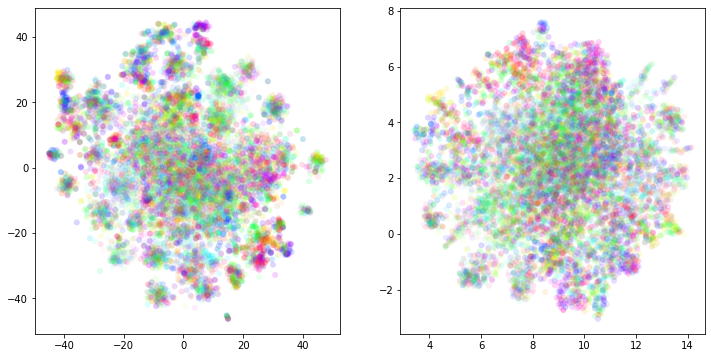

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[i].scatter(fit[:, 0], fit[:, 1], c=colors, alpha=alpha/4, edgecolor='none')
    #axes[i].scatter(fit[:, 0], fit[:, 1], c=hue, cmap='jet', alpha=alpha/4, edgecolor='none')

## By distance to center

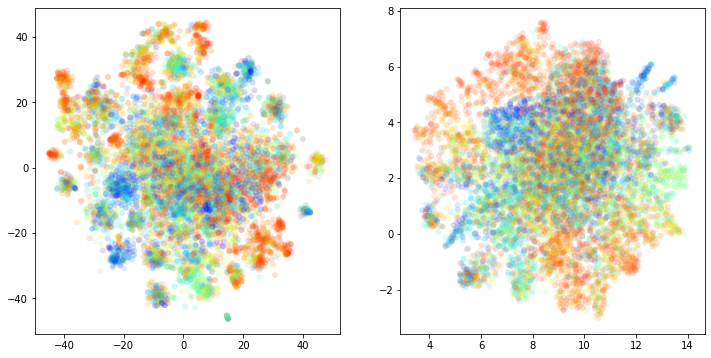

In [74]:
rho_cut = rho.copy()
rho_cut[rho > 0.5] = 0.5

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[i].scatter(fit[:, 0], fit[:, 1], c=rho_cut, alpha=0.15, cmap='jet', edgecolor='none')

## By HD

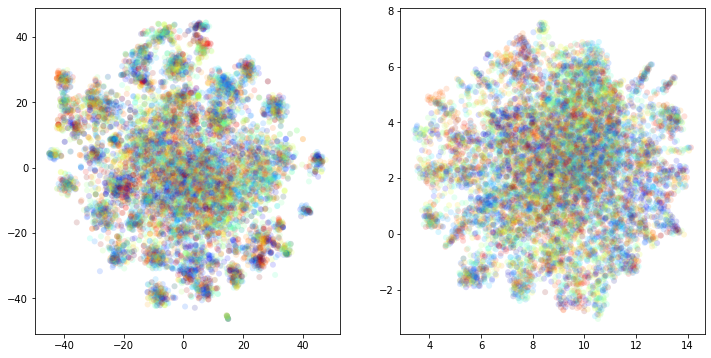

In [75]:
hd = tl[sound_events[:, 2].astype(np.int32)][:, 4]
hue_hd = (hd + np.pi) / (2 * np.pi)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[i].scatter(fit[:, 0], fit[:, 1], c=hue_hd, cmap='jet', alpha=0.15, edgecolor='none')

## Random

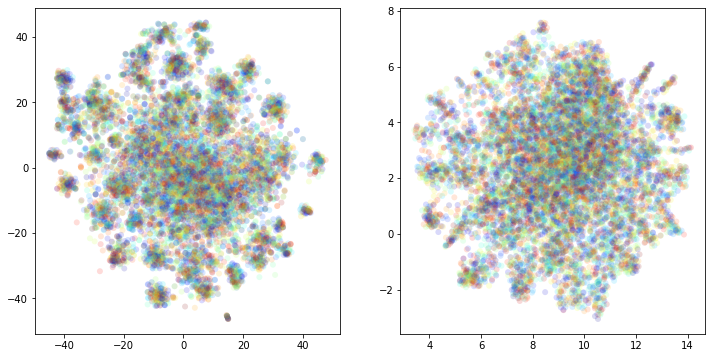

In [76]:
c_rand = np.random.rand(len(fit))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, fit in enumerate([tsne_fit, umap_fit]):
    axes[i].scatter(fit[:, 0], fit[:, 1], c=c_rand, cmap='jet', alpha=0.15, edgecolor='none')

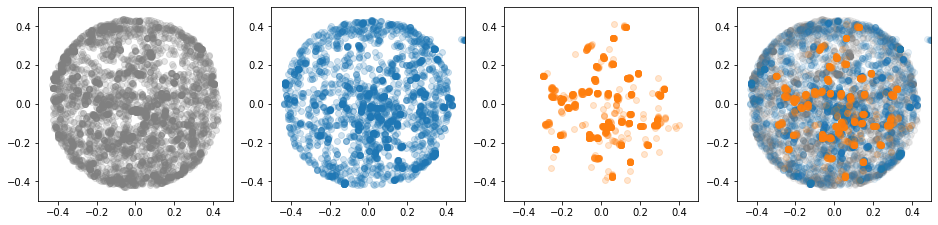

In [77]:
# animal position
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]

idxs_to_plot = [idxs_sil_ev, idxs_bgr_ev, idxs_tgt_ev]
colors = ['grey', 'tab:blue', 'tab:orange']

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes[:-1]):
    axes[i].scatter(x_pos_ev[idxs_to_plot[i]], y_pos_ev[idxs_to_plot[i]], color=colors[i], alpha=0.2)
    axes[i].set_xlim(-0.5, 0.5)
    axes[i].set_ylim(-0.5, 0.5)
    axes[i].set_aspect('equal')
        
axes[3].scatter(x_pos_ev[idxs_sil_ev], y_pos_ev[idxs_sil_ev], color='grey', alpha=0.1)
axes[3].scatter(x_pos_ev[idxs_bgr_ev], y_pos_ev[idxs_bgr_ev], color='tab:blue', alpha=0.1)
axes[3].scatter(x_pos_ev[idxs_tgt_ev], y_pos_ev[idxs_tgt_ev], color='tab:orange', alpha=0.2)
axes[3].set_xlim(-0.5, 0.5)
axes[3].set_ylim(-0.5, 0.5)
axes[3].set_aspect('equal')

## TGT / DIS only

In [22]:
idxs_di1 = np.union1d(idxs_tgt_ev, idxs_di1_ev)
idxs_dia = np.union1d(idxs_di1, idxs_di2_ev)
idxs_dia.sort()

tgt_dis_labels = sound_events[idxs_dia][:, 1]
unit_mx_tgt_dis = unit_mx.T[idxs_dia]

In [23]:
tsne_tgt = TSNE(n_components=2, perplexity=50, random_state=0)
tsne_tgt_fit = tsne_tgt.fit_transform(unit_mx_tgt_dis)
    
umap_tgt = UMAP(n_components=2, n_neighbors=30, min_dist=0.5, random_state=0)
umap_tgt_fit = umap_tgt.fit_transform(unit_mx_tgt_dis)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


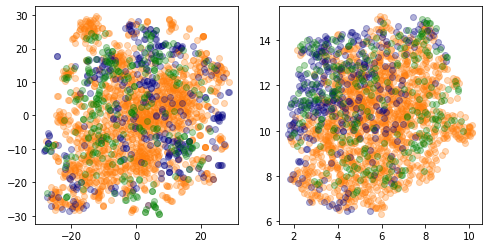

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, fit in enumerate([tsne_tgt_fit, umap_tgt_fit]):
    axes[i].scatter(fit[tgt_dis_labels == 2][:, 0], fit[tgt_dis_labels == 2][:, 1], color='tab:orange', alpha=0.3)
    axes[i].scatter(fit[tgt_dis_labels == 3][:, 0], fit[tgt_dis_labels == 3][:, 1], color='navy', alpha=0.3)
    axes[i].scatter(fit[tgt_dis_labels == 4][:, 0], fit[tgt_dis_labels == 4][:, 1], color='green', alpha=0.3)

### Progression in time

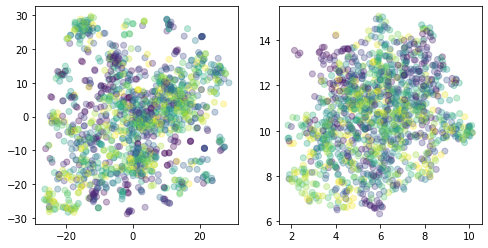

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, fit in enumerate([tsne_tgt_fit, umap_tgt_fit]):
    for period in get_sound_event_period_idxs(sound_events[idxs_dia], 2):
        #if period[1] - period[0] <= 24:
        p_idxs = np.arange(period[0], period[1])
        clrs = np.arange(len(p_idxs))
        axes[i].scatter(fit[p_idxs][:, 0], fit[p_idxs][:, 1], c=clrs, cmap='viridis', alpha=0.3)
        #axes[i].plot(fit[p_idxs][:, 0], fit[p_idxs][:, 1], alpha=0.3)


In [26]:
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
tgt_succ_xy = np.zeros([len(tgt_mx_succ), 2])

for i, tgt_rec in enumerate(tgt_mx_succ):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_xy[i] = [x_pos.mean(), y_pos.mean()]

In [27]:
idxs_tgt_beg_dia = []
idxs_tgt_end_dia = []
for tgt_succ in tgt_mx_succ:
    idxs_tgt_beg_dia.append(np.where(idxs_dia == tgt_succ[0])[0][0])
    idxs_tgt_end_dia.append(np.where(idxs_dia == tgt_succ[1])[0][0])

idxs_tgt_dia = np.column_stack([idxs_tgt_beg_dia, idxs_tgt_end_dia])

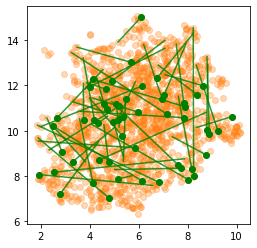

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(fit[tgt_dis_labels == 2][:, 0], fit[tgt_dis_labels == 2][:, 1], color='tab:orange', alpha=0.3)
#ax.scatter(fit[tgt_dis_labels == 3][:, 0], fit[tgt_dis_labels == 3][:, 1], color='navy', alpha=0.3)
#ax.scatter(fit[tgt_dis_labels == 4][:, 0], fit[tgt_dis_labels == 4][:, 1], color='green', alpha=0.3)

for tgt_dia in idxs_tgt_dia:
    ax.plot([fit[tgt_dia[0]][0], fit[tgt_dia[1]][0]], [fit[tgt_dia[0]][1], fit[tgt_dia[1]][1]], alpha=0.8, color='green')
ax.scatter(fit[idxs_tgt_dia[:, 1]][:, 0], fit[idxs_tgt_dia[:, 1]][:, 1], color='green')

## PCA on population activity

In [70]:
from sklearn import decomposition

### Stationary: inside TGT, BGR and SIL

In [236]:
pca_tgt   = decomposition.PCA(n_components=3)
pca_tgt_X = pca_tgt.fit_transform(unit_mx.T[idxs_tgt_ev])

idxs_bgr_sta_ev = np.intersect1d(idxs_bgr_ev, idxs_sta_ev)
pca_bgr_sta   = decomposition.PCA(n_components=3)
pca_bgr_sta_X = pca_bgr_sta.fit_transform(unit_mx.T[idxs_bgr_sta_ev])

idxs_sil_sta_ev = np.intersect1d(idxs_sil_ev, idxs_sta_ev)
pca_sil_sta   = decomposition.PCA(n_components=3)
pca_sil_sta_X = pca_sil_sta.fit_transform(unit_mx.T[idxs_sil_sta_ev])

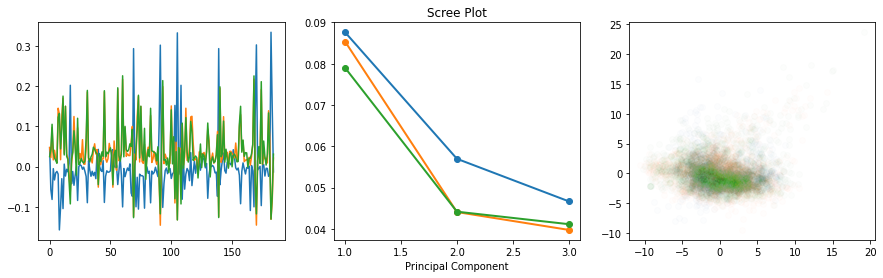

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
for PCA in [pca_tgt, pca_bgr_sta, pca_sil_sta]:
    ax.plot(PCA.components_[0])

ax = axes[1]
for PCA in [pca_tgt, pca_bgr_sta, pca_sil_sta]:
    PC_values = np.arange(PCA.n_components_) + 1
    ax.plot(PC_values, PCA.explained_variance_ratio_, 'o-', linewidth=2)
    ax.set_title('Scree Plot')
    ax.set_xlabel('Principal Component')

ax = axes[2]
for PCA in [pca_tgt_X, pca_bgr_sta_X, pca_sil_sta_X]:
    ax.scatter(PCA[:, 0], PCA[:, 1], alpha=0.01)

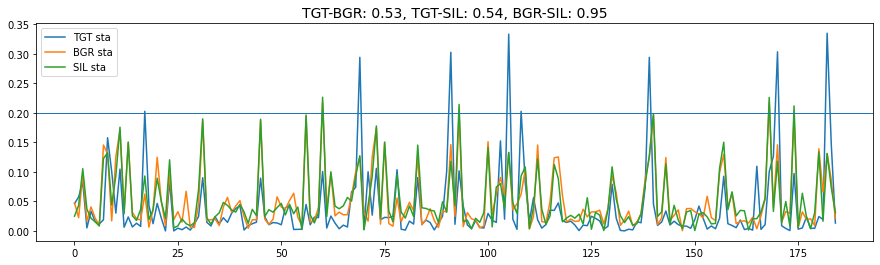

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

comps = [
    np.abs(pca_tgt.components_[0]),
    np.abs(pca_bgr_sta.components_[0]),
    np.abs(pca_sil_sta.components_[0])
]

ax.plot(comps[0], label='TGT sta')
ax.plot(comps[1], label='BGR sta')
ax.plot(comps[2], label='SIL sta')

coeffs = [
    np.corrcoef(comps[0], comps[1])[0][1],
    np.corrcoef(comps[0], comps[2])[0][1],
    np.corrcoef(comps[1], comps[2])[0][1]
]
ax.set_title('TGT-BGR: %.2f, TGT-SIL: %.2f, BGR-SIL: %.2f' % tuple(coeffs), fontsize=14)
ax.legend()
ax.axhline(0.2, lw=1)

### running inside BGR and SIL

In [240]:
idxs_bgr_run_ev = np.intersect1d(idxs_bgr_ev, idxs_run_ev)
idxs_sil_run_ev = np.intersect1d(idxs_sil_ev, idxs_run_ev)

pca_bgr_run   = decomposition.PCA(n_components=3)
pca_bgr_run_X = pca_bgr_run.fit_transform(unit_mx.T[idxs_bgr_run_ev])

pca_sil_run   = decomposition.PCA(n_components=3)
pca_sil_run_X = pca_sil_run.fit_transform(unit_mx.T[idxs_sil_run_ev])

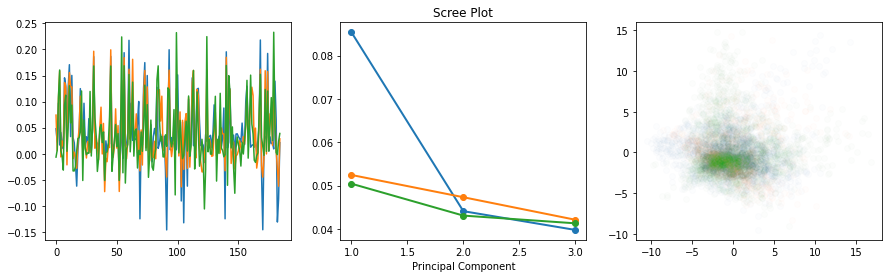

In [241]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
for PCA in [pca_bgr_sta, pca_bgr_run, pca_sil_run]:
    ax.plot(PCA.components_[0])

ax = axes[1]
for PCA in [pca_bgr_sta, pca_bgr_run, pca_sil_run]:
    PC_values = np.arange(PCA.n_components_) + 1
    ax.plot(PC_values, PCA.explained_variance_ratio_, 'o-', linewidth=2)
    ax.set_title('Scree Plot')
    ax.set_xlabel('Principal Component')

ax = axes[2]
for PCA in [pca_bgr_sta_X, pca_bgr_run_X, pca_sil_run_X]:
    ax.scatter(PCA[:, 0], PCA[:, 1], alpha=0.01)

### stationary versus running

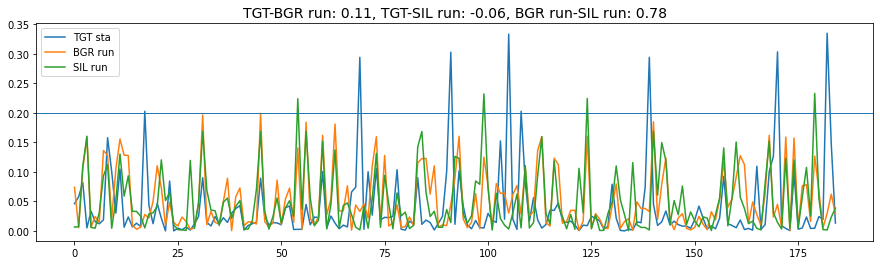

In [242]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

comps = [
    np.abs(pca_tgt.components_[0]),
    #np.abs(pca_bgr_sta.components_[0]),
    np.abs(pca_bgr_run.components_[0]),
    np.abs(pca_sil_run.components_[0])
]

ax.plot(comps[0], label='TGT sta')
ax.plot(comps[1], label='BGR run')
ax.plot(comps[2], label='SIL run')

coeffs = [
    np.corrcoef(comps[0], comps[1])[0][1],
    np.corrcoef(comps[0], comps[2])[0][1],
    np.corrcoef(comps[1], comps[2])[0][1]
]
ax.set_title('TGT-BGR run: %.2f, TGT-SIL run: %.2f, BGR run-SIL run: %.2f' % tuple(coeffs), fontsize=14)
ax.legend()
ax.axhline(0.2, lw=1)

## PCA within TGT for selected units

In [271]:
# unit IDs with high covariance
idxs_unit_pca = np.where(np.abs(pca_tgt.components_[0]) > 0.2)[0]
tgt_units = list(map(list(spike_times.keys()).__getitem__, idxs_unit_pca))

[x for x in zip(idxs_unit_pca, tgt_units)]

[(17, '1-364'),
 (69, '2-456'),
 (91, '3-144'),
 (105, '3-322'),
 (108, '3-39'),
 (139, '4-133'),
 (170, '4-481'),
 (182, '4-655')]

In [272]:
unit_mx_tgt_act = unit_mx[idxs_unit_pca]
unit_mx_tgt_act.shape

(8, 9599)

In [273]:
pca_tgt_act   = decomposition.PCA(n_components=3)
pca_tgt_act_X = pca_tgt_act.fit_transform(unit_mx_tgt_act.T[idxs_tgt_ev])

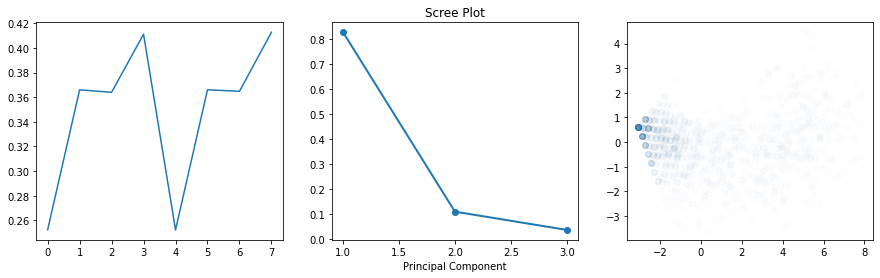

In [274]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(pca_tgt_act.components_[0])

ax = axes[1]
PC_values = np.arange(pca_tgt_act.n_components_) + 1
ax.plot(PC_values, pca_tgt_act.explained_variance_ratio_, 'o-', linewidth=2)
ax.set_title('Scree Plot')
ax.set_xlabel('Principal Component')

ax = axes[2]
ax.scatter(pca_tgt_act_X[:, 0], pca_tgt_act_X[:, 1], alpha=0.01)